## Importing The Libraries

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind


pd.options.display.float_format = '{:.4f}'.format
import warnings
warnings.filterwarnings("ignore")

In [59]:


# 1/Load .txt files, specifying the separator (e.g. tab '\t' or comma ',')df_web_data_pt_1 = pd.read_csv("/Users/cha/Documents/Ironhack2/UNIT_5/Project/Statistics/Datasets/df_final_web_data_pt_1.txt", sep="\t")
df_web_data_pt_1 = pd.read_csv("df_final_web_data_pt_1.txt", sep=",")
df_web_data_pt_2 = pd.read_csv("df_final_web_data_pt_2.txt", sep=",")
df_demo = pd.read_csv("df_final_demo.txt", sep=",")
df_experiment_clients = pd.read_csv("df_final_experiment_clients.txt", sep=",")





# 1. merge and consolidate
# Combine web data
web_data = pd.concat([df_web_data_pt_1, df_web_data_pt_2], ignore_index=True)

# Merge demographic and experimental data
df_demo_exp = df_demo.merge(df_experiment_clients, on='client_id', how='outer')

# Merge web interaction and demographic data
df = web_data.merge(df_demo_exp, on='client_id', how='left')

df = df.dropna()

# Check available columns
print("Colonnes disponibles après fusion :", df.columns)

# Fill in missing numeric and demographic values with 0
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(0)

# Assign “U” (Unknown) to missing gender values
df['gendr'] = df['gendr'].fillna('U')

# 3. Standardizing and cleaning columns
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Organize columns for usability
column_order = ['client_id', 'visitor_id', 'visit_id', 'date_time', 'process_step', 'variation', 'gendr', 'clnt_age', 'bal']
df = df[[col for col in column_order if col in df.columns] + [col for col in df.columns if col not in column_order]]

# 4. Removing Duplicates
cols_to_check = [col for col in ['visitor_id', 'client_id', 'process_step', 'date_time'] if col in df.columns]
df = df.drop_duplicates(subset=cols_to_check)

# 5. Data Type Adjustments
# Convertir date_time au format datetime
df['date_time'] = pd.to_datetime(df['date_time'])

# Adjust numeric columns
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 6. Enhancements and Segmentations
# Process Step Sorting
process_step_order = {step: f"{i}_{step}" for i, step in enumerate(sorted(df['process_step'].unique()))}
df['process_step'] = df['process_step'].map(process_step_order)
df['process_step'] = pd.Categorical(df['process_step'], ordered=True)

# Age Groups
def age_group(age):
    if age < 31:
        return '16-30'
    elif age < 41:
        return '31-40'
    elif age < 51:
        return '41-50'
    else:
        return '51+'

df['age_group'] = df['clnt_age'].apply(age_group)

# Balance Segments
def balance_segment(balance):
    if balance < 50000:
        return '0-50k'
    elif balance < 150000:
        return '50-150k'
    else:
        return '150k+'

df['balance_segment'] = df['bal'].apply(balance_segment)

df.head()


Colonnes disponibles après fusion : Index(['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time',
       'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr', 'num_accts',
       'bal', 'calls_6_mnth', 'logons_6_mnth', 'Variation'],
      dtype='object')


,client_id,visitor_id,visit_id,date_time,process_step,variation,gendr,clnt_age,bal,clnt_tenure_yr,clnt_tenure_mnth,num_accts,calls_6_mnth,logons_6_mnth,age_group,balance_segment
0,9988021,580560515_7732621733,781255054_21935453173_531117,2017-04-17 15:27:07,4_step_3,Test,U,79.0000,189023.8600,5.0000,64.0000,2.0000,1.0000,4.0000,51+,150k+
1,9988021,580560515_7732621733,781255054_21935453173_531117,2017-04-17 15:26:51,3_step_2,Test,U,79.0000,189023.8600,5.0000,64.0000,2.0000,1.0000,4.0000,51+,150k+
2,9988021,580560515_7732621733,781255054_21935453173_531117,2017-04-17 15:19:22,4_step_3,Test,U,79.0000,189023.8600,5.0000,64.0000,2.0000,1.0000,4.0000,51+,150k+
3,9988021,580560515_7732621733,781255054_21935453173_531117,2017-04-17 15:19:13,3_step_2,Test,U,79.0000,189023.8600,5.0000,64.0000,2.0000,1.0000,4.0000,51+,150k+
4,9988021,580560515_7732621733,781255054_21935453173_531117,2017-04-17 15:18:04,4_step_3,Test,U,79.0000,189023.8600,5.0000,64.0000,2.0000,1.0000,4.0000,51+,150k+


In [60]:
df.isnull().sum()

client_id           0
visitor_id          0
visit_id            0
date_time           0
process_step        0
variation           0
gendr               0
clnt_age            0
bal                 0
clnt_tenure_yr      0
clnt_tenure_mnth    0
num_accts           0
calls_6_mnth        0
logons_6_mnth       0
age_group           0
balance_segment     0
dtype: int64

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 317123 entries, 0 to 637535
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         317123 non-null  int64         
 1   visitor_id        317123 non-null  object        
 2   visit_id          317123 non-null  object        
 3   date_time         317123 non-null  datetime64[ns]
 4   process_step      317123 non-null  category      
 5   variation         317123 non-null  object        
 6   gendr             317123 non-null  object        
 7   clnt_age          317123 non-null  float64       
 8   bal               317123 non-null  float64       
 9   clnt_tenure_yr    317123 non-null  float64       
 10  clnt_tenure_mnth  317123 non-null  float64       
 11  num_accts         317123 non-null  float64       
 12  calls_6_mnth      317123 non-null  float64       
 13  logons_6_mnth     317123 non-null  float64       
 14  age_group

In [62]:
df = df.reset_index(drop=True)

In [63]:
df.to_csv("cleaned_data.csv", index=False)

## EDA

In [64]:
df.describe()

,client_id,date_time,clnt_age,bal,clnt_tenure_yr,clnt_tenure_mnth,num_accts,calls_6_mnth,logons_6_mnth
count,317123.0000,317123,317123.0000,317123.0000,317123.0000,317123.0000,317123.0000,317123.0000,317123.0000
mean,5009926.2722,2017-04-19 21:55:47.722479872,48.5283,160802.5096,12.1757,152.1293,2.2621,3.2311,6.2693
min,555.0000,2017-03-15 00:19:28,17.0000,23789.4400,2.0000,33.0000,1.0000,0.0000,3.0000
25%,2516332.0000,2017-04-04 12:55:55,34.5000,41033.5900,6.0000,82.0000,2.0000,1.0000,4.0000
50%,5049084.0000,2017-04-12 13:11:59,50.0000,69090.9800,11.0000,138.0000,2.0000,3.0000,6.0000
75%,7470491.0000,2017-04-28 09:08:21,61.0000,151161.7000,16.0000,193.0000,2.0000,6.0000,9.0000
max,9999832.0000,2017-06-20 23:57:06,96.0000,16320040.1500,55.0000,669.0000,7.0000,6.0000,9.0000
std,2873246.9721,NaN,15.6366,340868.1380,6.9584,83.1553,0.5407,2.1941,2.1801


- The average age of the client is 48.5 years old.
- The minimum age of the client is 17 and the maximum age is 

In [65]:
df["process_step"].unique()

['4_step_3', '3_step_2', '2_step_1', '1_start', '0_confirm']
Categories (5, object): ['0_confirm' < '1_start' < '2_step_1' < '3_step_2' < '4_step_3']

### Identifying the primary clients (i.e the ones who are in the control group interacting with the Vanguard's traditional online system)

In [66]:
control_group =  df[df["variation"]=="Control"] 
control_group.head()

,client_id,visitor_id,visit_id,date_time,process_step,variation,gendr,clnt_age,bal,clnt_tenure_yr,clnt_tenure_mnth,num_accts,calls_6_mnth,logons_6_mnth,age_group,balance_segment
13,4033851,762728880_76361333336,949661017_22392791362_127391,2017-04-05 12:29:03,0_confirm,Control,M,63.5000,142642.2600,12.0000,149.0000,2.0000,5.0000,8.0000,51+,50-150k
14,4033851,762728880_76361333336,949661017_22392791362_127391,2017-04-05 12:29:01,0_confirm,Control,M,63.5000,142642.2600,12.0000,149.0000,2.0000,5.0000,8.0000,51+,50-150k
15,4033851,762728880_76361333336,949661017_22392791362_127391,2017-04-05 12:28:52,0_confirm,Control,M,63.5000,142642.2600,12.0000,149.0000,2.0000,5.0000,8.0000,51+,50-150k
16,4033851,762728880_76361333336,949661017_22392791362_127391,2017-04-05 12:26:08,4_step_3,Control,M,63.5000,142642.2600,12.0000,149.0000,2.0000,5.0000,8.0000,51+,50-150k
17,4033851,762728880_76361333336,949661017_22392791362_127391,2017-04-05 12:24:43,3_step_2,Control,M,63.5000,142642.2600,12.0000,149.0000,2.0000,5.0000,8.0000,51+,50-150k


In [67]:
control_group["process_step"].value_counts()

process_step
1_start      45361
2_step_1     29533
3_step_2     25764
4_step_3     22495
0_confirm    17329
Name: count, dtype: int64

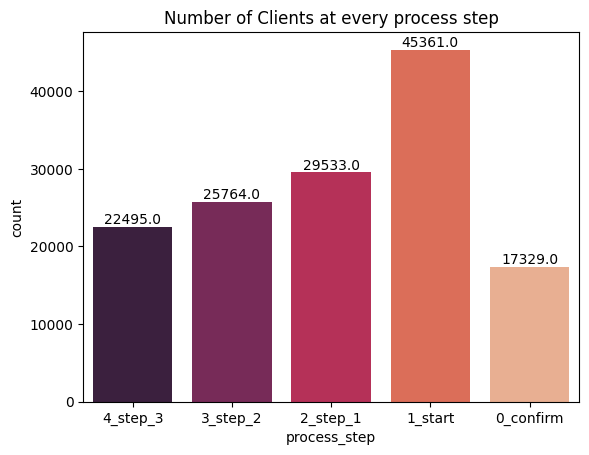

In [68]:
ax = sns.countplot(x= control_group["process_step"],palette="rocket", order = ['4_step_3', '3_step_2', '2_step_1', '1_start', '0_confirm'])
# add labels on on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.05, str(p.get_height()), ha='center', va='bottom')
plt.title("Number of Clients at every process step")
plt.show()

In [69]:
test_group =  df[df["variation"]=="Test"] 
test_group.head()

,client_id,visitor_id,visit_id,date_time,process_step,variation,gendr,clnt_age,bal,clnt_tenure_yr,clnt_tenure_mnth,num_accts,calls_6_mnth,logons_6_mnth,age_group,balance_segment
0,9988021,580560515_7732621733,781255054_21935453173_531117,2017-04-17 15:27:07,4_step_3,Test,U,79.0000,189023.8600,5.0000,64.0000,2.0000,1.0000,4.0000,51+,150k+
1,9988021,580560515_7732621733,781255054_21935453173_531117,2017-04-17 15:26:51,3_step_2,Test,U,79.0000,189023.8600,5.0000,64.0000,2.0000,1.0000,4.0000,51+,150k+
2,9988021,580560515_7732621733,781255054_21935453173_531117,2017-04-17 15:19:22,4_step_3,Test,U,79.0000,189023.8600,5.0000,64.0000,2.0000,1.0000,4.0000,51+,150k+
3,9988021,580560515_7732621733,781255054_21935453173_531117,2017-04-17 15:19:13,3_step_2,Test,U,79.0000,189023.8600,5.0000,64.0000,2.0000,1.0000,4.0000,51+,150k+
4,9988021,580560515_7732621733,781255054_21935453173_531117,2017-04-17 15:18:04,4_step_3,Test,U,79.0000,189023.8600,5.0000,64.0000,2.0000,1.0000,4.0000,51+,150k+


In [70]:
test_group["process_step"].value_counts()

process_step
1_start      55753
2_step_1     38651
3_step_2     30888
4_step_3     25755
0_confirm    25594
Name: count, dtype: int64

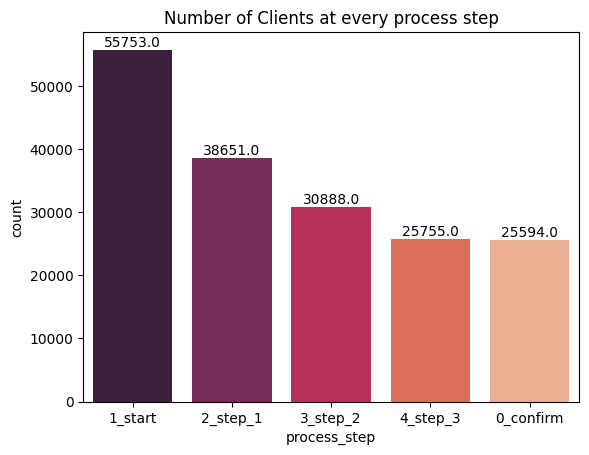

In [71]:
ax = sns.countplot(x= test_group["process_step"],palette="rocket", order = ['1_start', '2_step_1', '3_step_2', '4_step_3','0_confirm'])

# add labels on on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.05, str(p.get_height()), ha='center', va='bottom')
plt.title("Number of Clients at every process step")
plt.show()

In [72]:
balance_segment_counts_test = test_group['balance_segment'].value_counts()
balance_segment_counts_control = control_group['balance_segment'].value_counts()

Text(0, 0.5, 'Count')

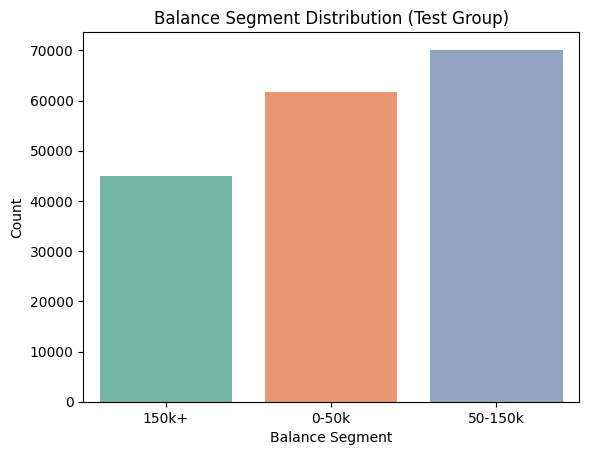

In [73]:
sns.countplot(x='balance_segment', data=test_group, palette='Set2')
plt.title('Balance Segment Distribution (Test Group)')
plt.xlabel('Balance Segment')
plt.ylabel('Count')



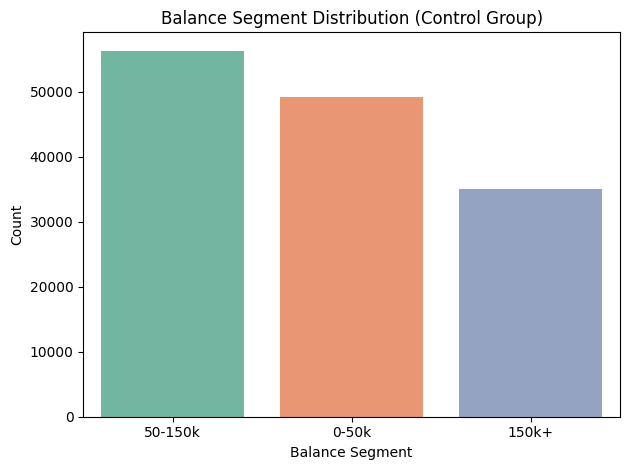

In [74]:
sns.countplot(x='balance_segment', data=control_group, palette='Set2')
plt.title('Balance Segment Distribution (Control Group)')
plt.xlabel('Balance Segment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Client Tenure (Years)')

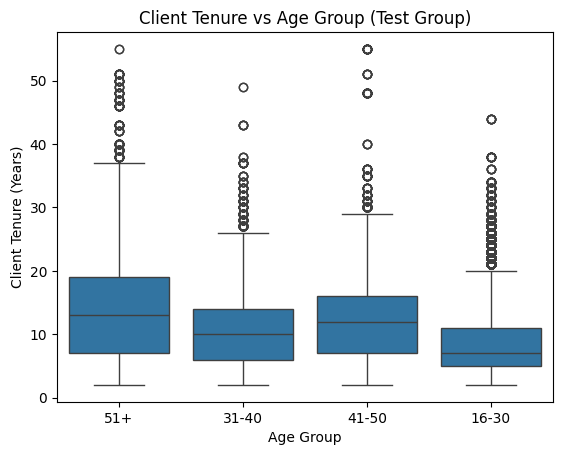

In [75]:
sns.boxplot(x='age_group', y='clnt_tenure_yr', data=test_group)
plt.title('Client Tenure vs Age Group (Test Group)')
plt.xlabel('Age Group')
plt.ylabel('Client Tenure (Years)')

Text(0, 0.5, 'Client Tenure (Years)')

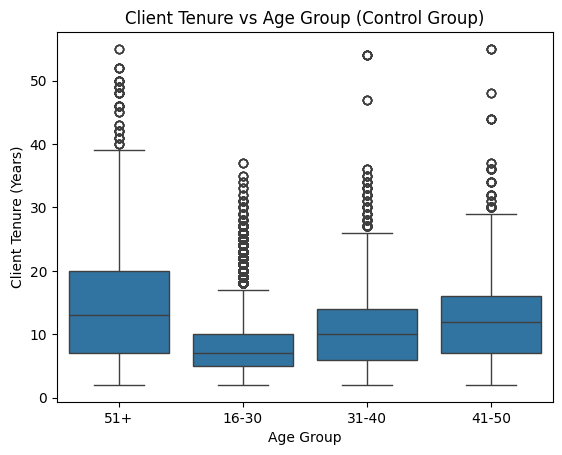

In [76]:
sns.boxplot(x='age_group', y='clnt_tenure_yr', data=control_group)
plt.title('Client Tenure vs Age Group (Control Group)')
plt.xlabel('Age Group')
plt.ylabel('Client Tenure (Years)')

Text(0, 0.5, 'Frequency')

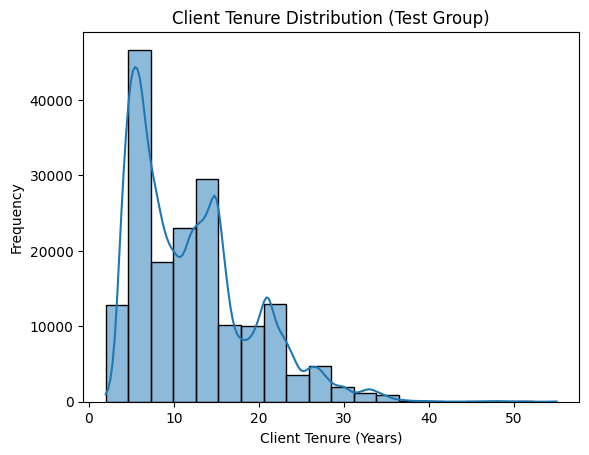

In [77]:
sns.histplot(test_group['clnt_tenure_yr'], bins=20, kde=True)
plt.title('Client Tenure Distribution (Test Group)')
plt.xlabel('Client Tenure (Years)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

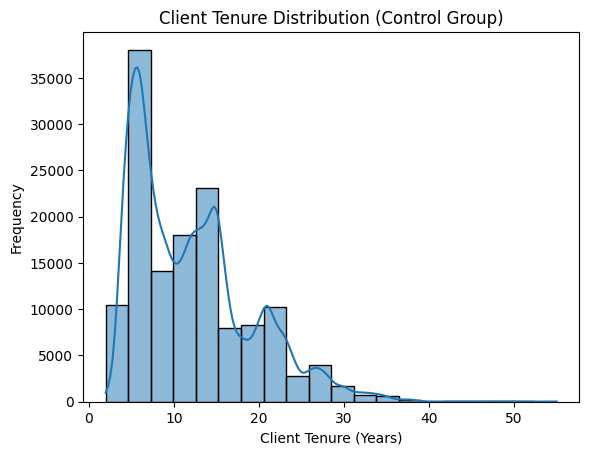

In [78]:
sns.histplot(control_group['clnt_tenure_yr'], bins=20, kde=True)
plt.title('Client Tenure Distribution (Control Group)')
plt.xlabel('Client Tenure (Years)')
plt.ylabel('Frequency')

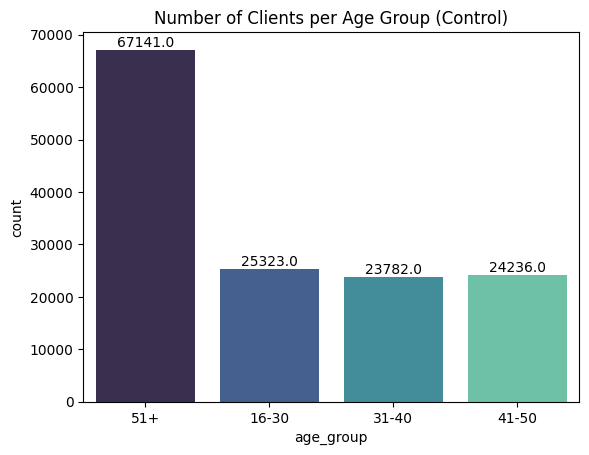

In [79]:
ax = sns.countplot(x= control_group["age_group"],palette="mako")
# add labels on on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.05, str(p.get_height()), ha='center', va='bottom')
plt.title("Number of Clients per Age Group (Control)")
plt.show()

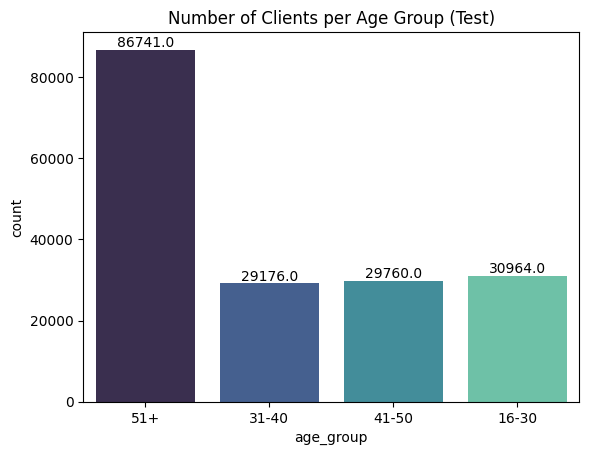

In [80]:
ax = sns.countplot(x= test_group["age_group"],palette="mako")
# add labels on on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.05, str(p.get_height()), ha='center', va='bottom')
plt.title("Number of Clients per Age Group (Test)")
plt.show()

### KPIS 

- conversion rate
- drop off rate
- bounce rate





In [81]:
## KPIS: Drop-off rate

control_group["process_step"].value_counts()


process_step
1_start      45361
2_step_1     29533
3_step_2     25764
4_step_3     22495
0_confirm    17329
Name: count, dtype: int64

In [82]:
test_group["process_step"].value_counts()


process_step
1_start      55753
2_step_1     38651
3_step_2     30888
4_step_3     25755
0_confirm    25594
Name: count, dtype: int64

In [83]:
## Drop-off rate

df_variation = df.groupby(["variation", "process_step"])["client_id"].count().unstack()
df_variation



process_step,0_confirm,1_start,2_step_1,3_step_2,4_step_3
variation,,,,,
Control,17329,45361,29533,25764,22495
Test,25594,55753,38651,30888,25755


In [84]:
ordre_etapes = ["1_start", "2_step_1", "3_step_2", "4_step_3", "0_confirm"]

df_variation_sorted = df_variation[ordre_etapes]

df_variation_sorted


process_step,1_start,2_step_1,3_step_2,4_step_3,0_confirm
variation,,,,,
Control,45361,29533,25764,22495,17329
Test,55753,38651,30888,25755,25594


In [85]:
df_variation_dropoff = df_variation_sorted.diff(axis=1) / df_variation_sorted.shift(axis=1) * 100
df_variation_dropoff

process_step,1_start,2_step_1,3_step_2,4_step_3,0_confirm
variation,,,,,
Control,NaN,-34.8934,-12.7620,-12.6882,-22.9651
Test,NaN,-30.6746,-20.0849,-16.6181,-0.6251


In [86]:
df_variation_dropoff_percentage = df_variation_dropoff.applymap(lambda x: f"{x:.2f}%" if pd.notnull(x) else "N/A")
df_variation_dropoff_percentage

process_step,1_start,2_step_1,3_step_2,4_step_3,0_confirm
variation,,,,,
Control,N/A,-34.89%,-12.76%,-12.69%,-22.97%
Test,N/A,-30.67%,-20.08%,-16.62%,-0.63%


#### Drop-off rates 

- The Control group has a higher drop-off rate at 2_step_1 (-34.89%) compared to the Test group (-30.67%), meaning that more users continued the process in the Test group at this step. At the confirmation stage (0_confirm), the Test group experiences significantly less drop-off (-0.63%) compared to the Control group (-22.97%). This indicates that the innovation has a strong positive impact on user retention at this final step, helping more users complete the process successfully.


- This analysis suggests that while the innovation may need improvements at earlier steps (like 3_step_2	4_step_3), it is highly effective at the confirmation stage, where it dramatically reduces user drop-off.

In [87]:
#### Bounce rate: Percentage of users who dropped off after 1_start

df_bounce_rate = (df_variation_sorted["2_step_1"] - df_variation_sorted["1_start"]) / df_variation_sorted["1_start"] * 100
df_bounce_rate




variation
Control   -34.8934
Test      -30.6746
dtype: float64

In [88]:
df_bounce_rate = df_bounce_rate.apply(lambda x: f"{abs(x):.2f}%" if pd.notnull(x) else "N/A")
df_bounce_rate

variation
Control    34.89%
Test       30.67%
dtype: object

In [89]:
# Group by variation and process step, then count unique clients at each step
df_variation = df.groupby(["variation", "process_step"])["client_id"].nunique().unstack()

# Ensure process steps are in correct order
process_steps = ["1_start", "2_step_1", "3_step_2", "4_step_3", "0_confirm"]
df_variation_sorted = df_variation[process_steps]

# Calculate Conversion Rate
df_conversion_rate = (df_variation_sorted["0_confirm"] / df_variation_sorted["1_start"]) * 100

# Calculate Drop-off Rate at each step
df_dropoff_rate = -df_variation_sorted.diff(axis=1) / df_variation_sorted.shift(axis=1) * 100

# Calculate Bounce Rate (users leaving after 1_start)
df_bounce_rate = ((df_variation_sorted["1_start"] - df_variation_sorted["2_step_1"]) / df_variation_sorted["1_start"]) * 100

# Format results for readability
df_conversion_rate = df_conversion_rate.apply(lambda x: f"{x:.2f}%" if pd.notnull(x) else "N/A")
df_dropoff_rate = df_dropoff_rate.applymap(lambda x: f"{x:.2f}%" if pd.notnull(x) else "N/A")
df_bounce_rate = df_bounce_rate.apply(lambda x: f"{x:.2f}%" if pd.notnull(x) else "N/A")


df_conversion_rate, df_dropoff_rate, df_bounce_rate


(variation
 Control    65.96%
 Test       70.04%
 dtype: object,
 process_step 1_start 2_step_1 3_step_2 4_step_3 0_confirm
 variation                                                
 Control          N/A   13.87%    7.46%    6.59%    11.41%
 Test             N/A    9.04%    8.28%    6.18%    10.51%,
 variation
 Control    13.87%
 Test        9.04%
 dtype: object)

- Higher user retention: The Test group retained more users throughout the process, especially in the early (2_step_1) and final stages (0_confirm).

- Better engagement: The lower bounce rate (9.04% vs. 13.87%) in the Test group indicates that users were more engaged from the start.

- Improved final conversion: A 4.08% increase in conversion rate (70.04% vs. 65.96%) shows that the Test group’s innovation effectively guided more users to completion.

In [90]:
# completion rate

completion_counts = df[df["process_step"]=="0_confirm"]["variation"].value_counts()
completion_counts

variation
Test       25594
Control    17329
Name: count, dtype: int64

In [91]:
total_counts = df["variation"].value_counts()
total_counts

variation
Test       176641
Control    140482
Name: count, dtype: int64

In [92]:
completion_rate =  (completion_counts/total_counts)*100
completion_rate

variation
Test      14.4893
Control   12.3354
Name: count, dtype: float64

In [93]:
df_completion_rate = (df_variation_sorted["0_confirm"] / df_variation_sorted["1_start"]) * 100

# Format the values for better readability
df_completion_rate = df_completion_rate.apply(lambda x: f"{x:.2f}%" if pd.notnull(x) else "N/A")

# Display the Completion Rate for both groups
df_completion_rate

variation
Control    65.96%
Test       70.04%
dtype: object

## Hypothesis Testing

HO: The completion rate of the test group is less than or equal to the control group.

H1: The completion rate of the test group is greater than the control group.

In [94]:
# calculate the completion couts for both groups
completion_test = completion_counts["Test"]
completion_control = completion_counts["Control"]

completion_test,completion_control

(25594, 17329)

In [95]:
# calulate the total users for both groups
total_test = total_counts["Test"]
total_control = total_counts["Control"]

total_test,total_control

(176641, 140482)

In [96]:
# calculate the completion rate
rate_test = completion_test/total_test
rate_control = completion_control/total_control

rate_test, rate_control

(0.14489274856913173, 0.12335388163608149)

In [97]:
observed_diff = rate_test - rate_control
observed_diff

0.021538866933050238

In [98]:
count = [completion_test,completion_control]
nobs = [total_test,total_control]

In [99]:
count , nobs

([25594, 17329], [176641, 140482])

In [100]:
z_stat, p_value = proportions_ztest(count,nobs, alternative='larger')

In [101]:
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

Z-statistic: 17.6122
P-value: 0.0000


HO: There is no difference in completion rates (The difference in completion rates is <=5%)

H1: There is a difference in the completion rates (The difference in completion rates is >5%)

In [102]:
threshold = 0.05 # 5%

if observed_diff >= threshold and p_value <= 0.05:
    print(" The increase in completion rate is statistically significant and meets the threshold of 5%.")
else:
    print(" The increase in completion rate does not meet the threshold of 5% for cost effectiveness.")

 The increase in completion rate does not meet the threshold of 5% for cost effectiveness.


HO:  There is no difference in the average client age between the test and control groups.

H1:  There is a difference in the average client age between the test and control groups.

In [103]:

# Filter age data for each group
age_test = df[df['variation'] == 'Test']['clnt_age'].dropna()
age_control = df[df['variation'] == 'Control']['clnt_age'].dropna()

# Perform a two-sample t-test
t_stat, p_value = ttest_ind(age_test, age_control, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the result
if p_value < 0.05:
    print("There is a statistically significant difference in average client age between the groups.")
else:
    print("There is no statistically significant difference in average client age between the groups.")


T-statistic: 7.8332
P-value: 0.0000
There is a statistically significant difference in average client age between the groups.


## Experiment Evaluation

In [105]:
# Check if the groups are equally divided
test_group_size = len(test_group)
control_group_size = len(control_group)
print(f"Test Group Size: {test_group_size}")
print(f"Control Group Size: {control_group_size}")

Test Group Size: 176641
Control Group Size: 140482


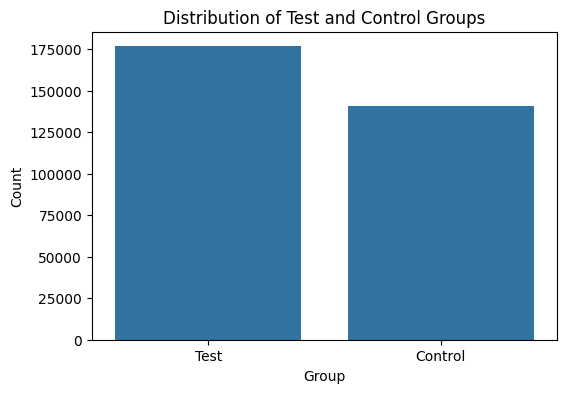

In [107]:
# Plot the group sizes
plt.figure(figsize=(6, 4))
sns.countplot(x='variation', data=df)
plt.title('Distribution of Test and Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.show()


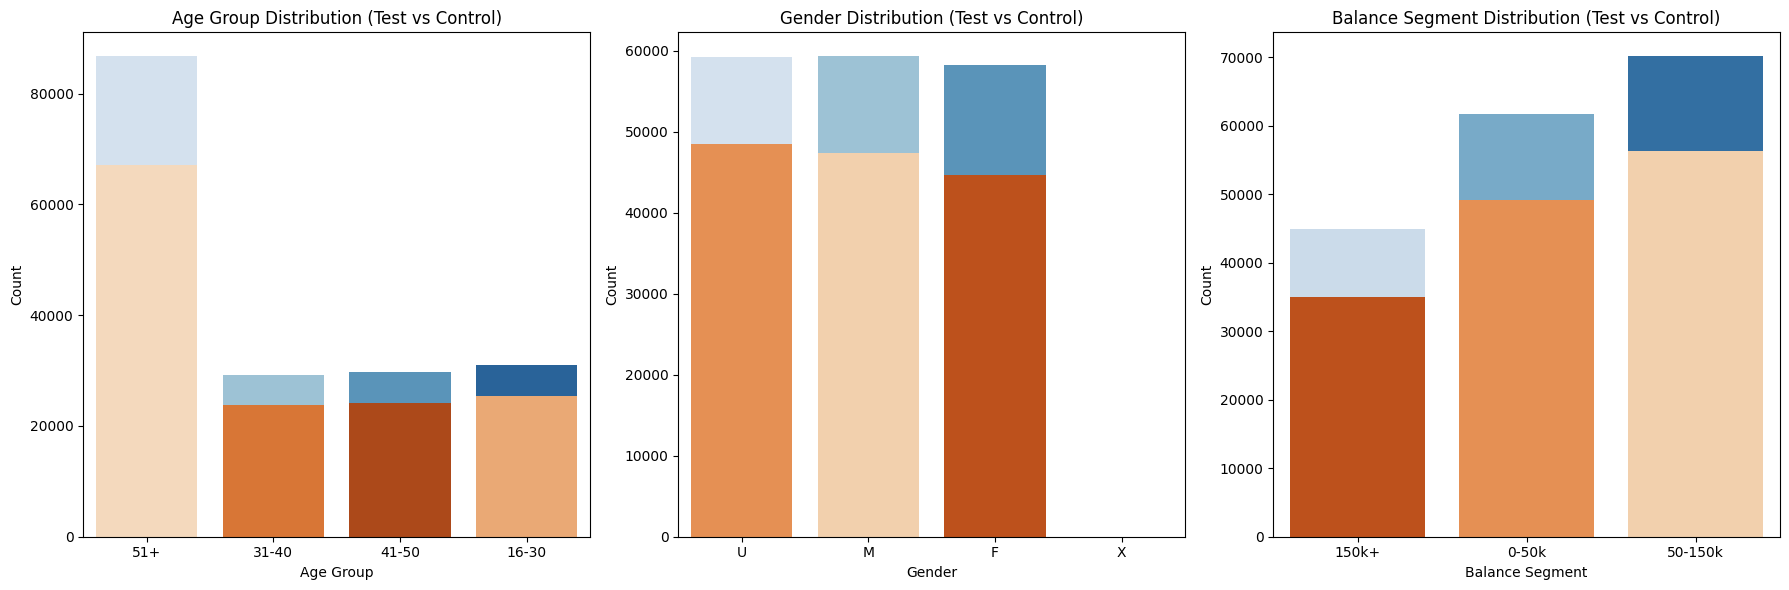

In [108]:
#Check if there are any biases in terms of demographics (age, gender, balance_segment)
# Compare the distributions of age, gender, and balance_segment for Test and Control groups
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.countplot(x='age_group', data=test_group, ax=axes[0], palette='Blues')
sns.countplot(x='age_group', data=control_group, ax=axes[0], palette='Oranges')
axes[0].set_title('Age Group Distribution (Test vs Control)')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Count')

# Gender Distribution
sns.countplot(x='gendr', data=test_group, ax=axes[1], palette='Blues')
sns.countplot(x='gendr', data=control_group, ax=axes[1], palette='Oranges')
axes[1].set_title('Gender Distribution (Test vs Control)')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')

# Balance Segment Distribution
sns.countplot(x='balance_segment', data=test_group, ax=axes[2], palette='Blues')
sns.countplot(x='balance_segment', data=control_group, ax=axes[2], palette='Oranges')
axes[2].set_title('Balance Segment Distribution (Test vs Control)')
axes[2].set_xlabel('Balance Segment')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

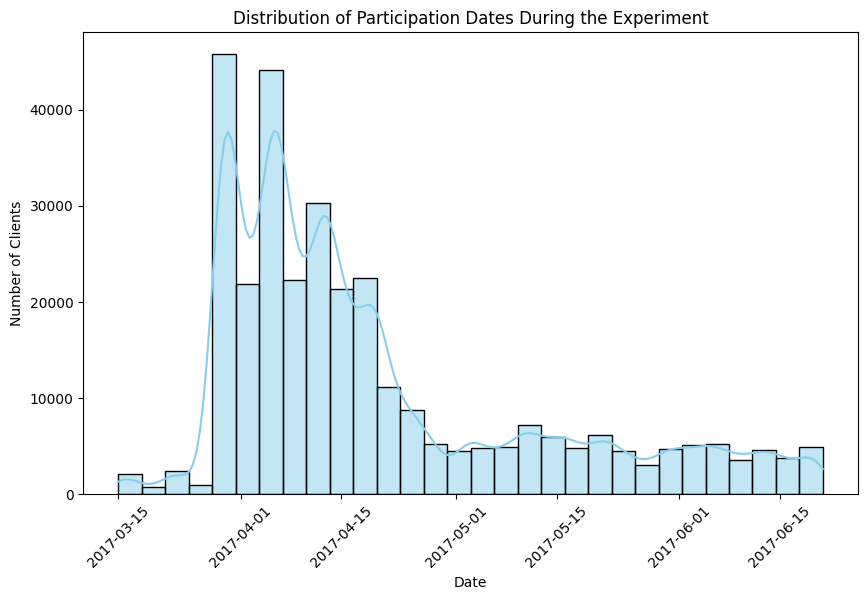

In [109]:
# Duration Analysis - Check the distribution of participation dates
plt.figure(figsize=(10, 6))
sns.histplot(df['date_time'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Participation Dates During the Experiment')
plt.xlabel('Date')
plt.ylabel('Number of Clients')
plt.xticks(rotation=45)
plt.show()


### 1. **Design Effectiveness**

- **Was the experiment well-structured?**
  - The experiment seems well-structured in terms of having clearly defined groups (Test and Control) with a structured period from **3/15/2017 to 6/20/2017**. However, the unequal distribution of clients between the groups (with the Test group being much larger than the Control group) raises questions about how clients were assigned to each group. Ideally, clients should be randomly assigned to ensure that any observed differences in outcomes are due to the design changes rather than group imbalances.

- **Were clients randomly and equally divided between the old and new designs?**
  - Based on the data, the **Test group** has **176,641 clients**, while the **Control group** has **140,482 clients**, which shows that the division was not equal. This imbalance suggests that there might have been some issue with the randomization or allocation process. A more equal distribution would have been ideal for reducing biases and ensuring the validity of the results.

- **Were there any biases?**
  - From the demographic analysis (age, gender, and balance segment), the **Test** and **Control** groups have different distributions, particularly in **age groups** and **balance segments**, indicating a potential **bias**. This difference could skew results and affect the validity of the findings, as these demographic factors may influence client behavior during the experiment.


### 2. **Duration Assessment**

- **Was the timeframe of the experiment (from 3/15/2017 to 6/20/2017) adequate to gather meaningful data and insights?**
  - The timeframe includes **approximately 3 months**, which might be sufficient in many cases, but the participation data indicates a **significant concentration of client activity around early April**. This clustering suggests that clients may have rushed to participate early in the experiment. The uneven distribution over the experimental period could limit the ability to draw meaningful conclusions about the effectiveness of the design over the entire period. The experiment's duration could potentially have been extended or participation more evenly spread out to gather better insights.



### 3. **Additional Data Needs**

- **What other data, if available, could enhance the analysis?**
  - Additional data that could enhance the analysis includes:
    - **Client interaction metrics** (e.g., time spent on each step of the process, clicks, navigation patterns) could help in understanding how users interacted with the new design versus the old design.
    - **User feedback** or **survey data** regarding the experience could provide insights into the reasons behind completion or abandonment.
    - **External factors** such as promotional campaigns, system downtimes, or other market factors could influence the results and should be accounted for if available.